# Load modules

In [1]:
# pip install seaborn

In [2]:
# pip install pyabc

In [3]:
# pip install xlrd

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image
from functools import partial
import pickle
import pandas as pd
import seaborn as sns
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
import pyabc.visualization
from pyabc.visualization import plot_kde_2d

# Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

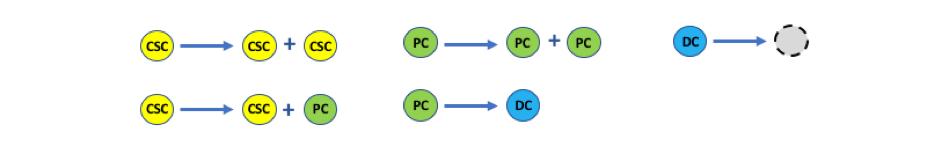

In [5]:
Image("Lan.png")

In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * probability
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - probability)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma

# Simulation for a single passage

In [6]:
parameters = {
    "Omega":0.15,
    "Probability":0.15,
    "Lambda":1.0,
    "Gamma":0.48}

countingTimePoints = np.array([80,65,70])

In [7]:
def clonalGrowth(inject, testParameters, time):
    k1 = parameters["Omega"] * parameters["Probability"]
    k2 = parameters["Omega"] * (1 - parameters["Probability"])
    k3 = parameters["Lambda"]*0.5
    k4 = parameters["Lambda"]*0.5
    k5 = parameters["Gamma"]
    S = inject["stem"]
    P = inject["progenitor"]
    D = 0
    reactionTime = 0      
    cont = True  
    while(cont):
        A1 = S*k1
        A2 = S*k2
        A3 = P*k3
        A4 = P*k4
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5
#         first random number generator to determine the time of nexr reaction
        if A0 > 0:
            r1 = random.random()
            t = np.log(1/r1)/A0
            if reactionTime + t > time:
                cont = False
            else:
                reactionTime += t
    #             second random number generator to determine which reaction occurs
                r2 = random.random()
                if r2 < A1/A0:
                    S += 1
                elif r2 < (A1+A2+A3)/A0:
                    P += 1
                elif r2 < (A1+A2+A3+A4)/A0:
                    P -= 1
                    D += 1
                else:
                    D -= 1
        else:
            cont = False
    return{"stem":S,"progenitor":P,"differentiated":D}


# Simulation for a serial passage

In [8]:
def transplantation(harvest,transplantationProb):
    stemHarvest = harvest["stem"]
    proHarvest = harvest["progenitor"]
    totalHarvest = stemHarvest + proHarvest
    stemReinject = 0
    proReinject = 0
    quieReinject = 0
    if totalHarvest > 0:
        stemProb = stemHarvest/totalHarvest
        proProb = proHarvest/totalHarvest
        stemReinject += np.random.binomial(n=totalHarvest, p=stemProb*transplantationProb)
        proReinject += np.random.binomial(n=totalHarvest, p=proProb*transplantationProb)
    else:
        pass
    return{"stem":stemReinject, "progenitor":proReinject}

def passageExpansion(primaryInject, testParameters, transplantationProb, seed):
    np.random.seed(seed)
    primaryHarvest = clonalGrowth(primaryInject, testParameters,countingTimePoints[0])
    secondaryInject = transplantation(primaryHarvest,transplantationProb)
    secondaryHarvest = clonalGrowth(secondaryInject, testParameters,countingTimePoints[1])
    tertiaryInject = transplantation(secondaryHarvest,transplantationProb)
    tertiaryHarvest = clonalGrowth(tertiaryInject, testParameters,countingTimePoints[2])
    S = np.array([primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]])
    P = np.array([primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]])
    D = np.array([primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]])
    return{"stem":S, "progenitor":P, "differentiated":D}

# Simulation for multiple clones

In [9]:
def multiGrowthSimulation(testParameters):
    simulation = 10000
    s = np.random.binomial(n=simulation, p=0.15)
    timeRange = int(len(countingTimePoints))
    multiGrowth = np.zeros((simulation,3,timeRange))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0}, testParameters, 0.37, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":1}, testParameters, 0.37, i)
        multiGrowth[i][0][:] = clone["stem"]
        multiGrowth[i][1][:] = clone["progenitor"]
        multiGrowth[i][2][:] = clone["differentiated"]
    return(multiGrowth)

def barFreqDistribution(testParameters):
    multiGrowth = multiGrowthSimulation(testParameters)
    clones = len(multiGrowth)
    primary = np.zeros(clones)
    secondary = np.zeros(clones)
    tertiary = np.zeros(clones)
    for clone in range(clones):
        primary[clone] = sum(np.array([multiGrowth[clone][cellType][0] for cellType in range(3)]))
        secondary[clone] = sum(np.array([multiGrowth[clone][cellType][1] for cellType in range(3)]))
        tertiary[clone] = sum(np.array([multiGrowth[clone][cellType][2] for cellType in range(3)]))
    primaryBarFreq = primary/sum(primary)
    secondaryBarFreq = secondary/sum(secondary)
    tertiaryBarFreq = tertiary/sum(tertiary)
    return{"primary":primaryBarFreq, "secondary":secondaryBarFreq, "tertiary": tertiaryBarFreq}


In [10]:
%time multiGrowth = multiGrowthSimulation(parameters)

CPU times: user 26.9 s, sys: 33.6 ms, total: 26.9 s
Wall time: 27 s


In [11]:
%time barFreqSim = barFreqDistribution(parameters)

CPU times: user 28.3 s, sys: 81.9 ms, total: 28.4 s
Wall time: 28.5 s


# search for parameters by comparing with Lan et al.'s experimental data

In [12]:
experiment = pd.read_excel("Table_1_experimental_clonal_size.xlsx")
experiment.head()

,Barcode,(1)719 Ipsi,(1)719 Contra,"(1,1V)719 Ipsi","(1,1V)719 Contra","(1,2V)719 Ipsi","(1,2V)719 Contra","(1,3V)719 Ipsi","(1,3V)719 Contra","(1,1T)719 Ipsi",...,"(1,1T,1V)719 Ipsi","(1,1T,1V)719 Contra","(1,1T,2V)719 Ipsi","(1,1T,2V)719 Contra","(1,1T,1T)719 Ipsi","(1,1T,1T)719 Contra","(1,1T,2T)719 Ipsi","(1,1T,2T)719 Contra","(1,1T,3T)719 Ipsi","(1,1T,3T)719 Contra"
0,AAATCAAGATCGAAACTGGTCAAACTG,0.001608,0.000614,0.002460,0.002479,0.002866,0.001103,0.004939,0.006328,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.005538,0.0,0.0,0.003078
1,AAATCAGGATGCAAACAGGTGTAACGG,0.001913,0.002575,0.003878,0.004407,0.003090,0.003762,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,AAATCCAGATCGAAATGGGTTTAACTT,0.002520,0.000000,0.005109,0.003288,0.005141,0.000000,0.002147,0.002167,0.00199,...,0.000000,0.0,0.003741,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,AAATCCAGATGGAAAGAGGTAGAACCC,0.001200,0.000743,0.001532,0.001386,0.002106,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,AAATCTCGATGGAAATCGGTCAAACAA,0.002975,0.001134,0.004104,0.002142,0.009155,0.001001,0.009424,0.010710,0.00199,...,0.002222,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [13]:
np.shape(experiment)

(2070, 39)

In [14]:
passage = experiment.columns
passage[1:]

Index(['(1)719 Ipsi', '(1)719 Contra', '(1,1V)719 Ipsi', '(1,1V)719 Contra',
       '(1,2V)719 Ipsi', '(1,2V)719 Contra', '(1,3V)719 Ipsi',
       '(1,3V)719 Contra', '(1,1T)719 Ipsi', '(1,1T)719 Contra',
       '(1,2T)719 Ipsi', '(1,2T)719 Contra', '(1C,1)719 Ipsi',
       '(1C,1)719 Contra', '(1C,2)719 Ipsi', '(1C,2)719 Contra',
       '(1,2V,1)719 Ipsi', '(1,2V,1)719 Contra', '(1,2V,2)719 Ipsi',
       '(1,2V,2)719 Contra', '(1,2V,3)719 Ipsi', '(1,2V,3)719 Contra',
       '(1,3V,1V)719 Ipsi', '(1,3V,1V)719 Contra', '(1,3V,2V)719 Ipsi',
       '(1,3V,2V)719 Contra', '(1,3V,1T)719 Ipsi', '(1,3V,1T)719 Contra',
       '(1,1T,1V)719 Ipsi', '(1,1T,1V)719 Contra', '(1,1T,2V)719 Ipsi',
       '(1,1T,2V)719 Contra', '(1,1T,1T)719 Ipsi', '(1,1T,1T)719 Contra',
       '(1,1T,2T)719 Ipsi', '(1,1T,2T)719 Contra', '(1,1T,3T)719 Ipsi',
       '(1,1T,3T)719 Contra'],
      dtype='object')

In [15]:
primaryExpBarFreq = np.vstack([experiment["(1)719 Ipsi"], experiment["(1)719 Contra"]])
secondaryExpBarFreq = np.vstack([
#     experiment["(1,1V)719 Ipsi"], experiment["(1,1V)719 Contra"],
                       experiment["(1,2V)719 Ipsi"], experiment["(1,2V)719 Contra"],
#                        experiment["(1,3V)719 Ipsi"], experiment["(1,3V)719 Contra"],
#                        experiment["(1,1T)719 Ipsi"], experiment["(1,1T)719 Contra"],
#                        experiment["(1,2T)719 Ipsi"], experiment["(1,2T)719 Contra"],
#                        experiment["(1C,1)719 Ipsi"], experiment["(1C,1)719 Contra"],
#                        experiment["(1C,2)719 Ipsi"], experiment["(1C,2)719 Contra"]
                      ])
tertiaryExpBarFreq = np.vstack([experiment["(1,2V,1)719 Ipsi"], experiment["(1,2V,1)719 Contra"]
#                       ,experiment["(1,2V,2)719 Ipsi"], experiment["(1,2V,2)719 Contra"],
#                       experiment["(1,2V,3)719 Ipsi"], experiment["(1,2V,3)719 Contra"],
#                       experiment["(1,3V,1V)719 Ipsi"], experiment["(1,3V,1V)719 Contra"],
#                       experiment["(1,3V,2V)719 Ipsi"], experiment["(1,3V,2V)719 Contra"],
#                       experiment["(1,3V,1T)719 Ipsi"], experiment["(1,3V,1T)719 Contra"],
#                       experiment["(1,1T,1V)719 Ipsi"], experiment["(1,1T,1V)719 Contra"],
#                       experiment["(1,1T,2V)719 Ipsi"], experiment["(1,1T,2V)719 Contra"],
#                       experiment["(1,1T,1T)719 Ipsi"], experiment["(1,1T,1T)719 Contra"],
#                       experiment["(1,1T,2T)719 Ipsi"], experiment["(1,1T,2T)719 Contra"],
#                       experiment["(1,1T,3T)719 Ipsi"], experiment["(1,1T,3T)719 Contra"]
                     ])

primaryExp = np.array([np.mean(i) for i in np.transpose(primaryExpBarFreq)])
secondaryExp = np.array([np.mean(i) for i in np.transpose(secondaryExpBarFreq)])
tertiaryExp = np.array([np.mean(i) for i in np.transpose(tertiaryExpBarFreq)])


In [16]:
def setConstantBins(exp):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
    binWidth = max(exp)/100
    bins = np.array([(binWidth*n) for n in range(101)])
    return(bins)

priBins = setConstantBins(primaryExp)
secBins = setConstantBins(secondaryExp)
terBins = setConstantBins(tertiaryExp)


In [17]:
# priBase = 1/sum(primarySimCloneSize)
# secBase = 1/sum(secondarySimCloneSize)
# terBase = 1/sum(tertiarySimCloneSize)

# def setGeometricBins(sim, exp, base):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
#     nBin = int(round(np.log(maxBin/base)/np.log(2)+0.5))
#     binSize = np.append([0],[base*2**(n-1) for n in range(1,(nBin+1))])
#     bins = np.cumsum(binSize)
#     return(bins)

# def setArithmeticBins(sim, exp, base):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
#     nBin = int(round(np.sqrt(8*maxBin/base + 1)/2))
#     binSize = np.array([base*n for n in range(nBin+1)])
#     bins = np.cumsum(binSize)
#     return(bins)
    
# priAriBins = setArithmeticBins(primarySim, primaryExp, priBase)
# secAriBins = setArithmeticBins(secondarySim, secondaryExp, secBase)
# terAriBins = setArithmeticBins(tertiarySim, tertiaryExp, terBase)

In [18]:
def binnedBarcodeFrequency(barFreq,bins):
    binnedBarFreq = np.zeros(len(bins)-1)
    for B in range(len(bins)-1):
        index = np.all([[bins[B] <= barFreq], [bins[B+1] > barFreq]], axis = 0)
        binnedBarFreq[B] = sum(index[0])/len(barFreq)
    return(binnedBarFreq)

primaryExpBinned = binnedBarcodeFrequency(primaryExp,priBins)
secondaryExpBinned = binnedBarcodeFrequency(secondaryExp,secBins)
tertiaryExpBinned = binnedBarcodeFrequency(tertiaryExp,terBins)


In [19]:
def normalisation(probability):
    return(probability/sum(probability))

primaryExpNorm = normalisation(primaryExpBinned[1:])
secondaryExpNorm = normalisation(secondaryExpBinned[1:])
tertiaryExpNorm = normalisation(tertiaryExpBinned[1:])

exp = np.array([normalisation(primaryExpBinned[1:]),normalisation(secondaryExpBinned[1:]), normalisation(tertiaryExpBinned[1:])])

expBarFreq = {"barcodeFrequency":exp}

In [20]:
def determineTestParameters(testParameters): 
    barFreq = barFreqDistribution(testParameters)
    primaryBarFreq = barFreq["primary"]
    secondaryBarFreq = barFreq["secondary"]
    tertiaryBarFreq = barFreq["tertiary"]
    primaryBinned = binnedBarcodeFrequency(primaryBarFreq,priBins)
    secondaryBinned = binnedBarcodeFrequency(secondaryBarFreq,secBins)
    tertiaryBinned = binnedBarcodeFrequency(tertiaryBarFreq,terBins)
    primaryNorm = normalisation(primaryBinned[1:])
    secondaryNorm = normalisation(secondaryBinned[1:])
    tertiaryNorm = normalisation(tertiaryBinned[1:])
    return{"barcodeFrequency": np.array([primaryNorm, secondaryNorm, tertiaryNorm])}
    

In [21]:
%time simBarFreq = determineTestParameters(parameters)

CPU times: user 35 s, sys: 69.1 ms, total: 35.1 s
Wall time: 35.2 s


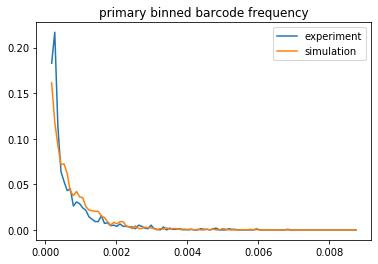

In [22]:
plt.plot(priBins[2:], exp[0], label = "experiment")
plt.plot(priBins[2:], simBarFreq["barcodeFrequency"][0], label = "simulation")
plt.title("primary binned barcode frequency")
plt.legend()
# plt.yscale('log')

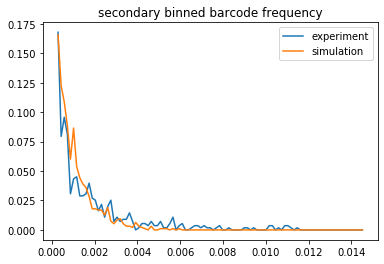

In [23]:
plt.plot(secBins[2:], exp[1], label = "experiment")
plt.plot(secBins[2:], simBarFreq["barcodeFrequency"][1], label = "simulation")
plt.title("secondary binned barcode frequency")
plt.legend()

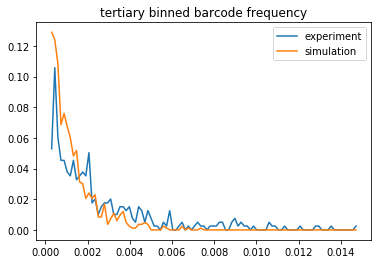

In [24]:
plt.plot(terBins[2:], exp[2], label = "experiment")
plt.plot(terBins[2:], simBarFreq["barcodeFrequency"][2], label = "simulation")
plt.title("tertiary binned barcode frequency")
plt.legend()

In [25]:
def ksStatistic(o,m):
    #print("%dx%d\n" % (len(o), len(m)) )
    k,p = stats.ks_2samp(o,m)
    return(k)

def distancePopulation(summStat,sim,data):
    modelResults = sim["barcodeFrequency"]
    observations = data["barcodeFrequency"] 
    results = [summStat(observations[i],modelResults[i]) for i in range(len(observations))]
#     print(sum(results))
    return(sum(results))


In [26]:
distancePopulation(ksStatistic, simBarFreq, expBarFreq)

0.7676767676767677

Now we are search for the best fitting parameters using pyABC.

In [27]:
limits = dict(Omega = (0, 0.3), 
              Probability = (0, 0.3), 
              Lambda = (0, 1.0),
              Gamma = (0, 0.96))

parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

db_path = pyabc.create_sqlite_db_id(file_ = "glioblatomaLanModel.db")

abc = ABCSMC(models = determineTestParameters,
             parameter_priors = parameter_prior,
             distance_function = partial(distancePopulation,ksStatistic), 
             population_size=50,
             transitions=LocalTransition(k_fraction=.3))

abc.new(db_path, expBarFreq);

INFO:History:Start <ABCSMC(id=1, start_time=2020-01-25 23:12:29.537949, end_time=None)>


In [28]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
Process Process-5:
Process Process-3:
Process Process-4:
Process Process-2:
Process Process-8:
Process Process-7:
Process Process-6:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  F

  File "<ipython-input-9-7c8fe16ed6bb>", line 8, in multiGrowthSimulation
    clone = passageExpansion({"stem":1,"progenitor":0}, testParameters, 0.37, i)
  File "<ipython-input-9-7c8fe16ed6bb>", line 17, in barFreqDistribution
    multiGrowth = multiGrowthSimulation(testParameters)
  File "<ipython-input-9-7c8fe16ed6bb>", line 8, in multiGrowthSimulation
    clone = passageExpansion({"stem":1,"progenitor":0}, testParameters, 0.37, i)
  File "<ipython-input-7-f835abc7aa8c>", line 22, in clonalGrowth
    t = np.log(1/r1)/A0
  File "<ipython-input-9-7c8fe16ed6bb>", line 8, in multiGrowthSimulation
    clone = passageExpansion({"stem":1,"progenitor":0}, testParameters, 0.37, i)
  File "<ipython-input-8-1f181a9b11f2>", line 23, in passageExpansion
    tertiaryHarvest = clonalGrowth(tertiaryInject, testParameters,countingTimePoints[2])
  File "<ipython-input-8-1f181a9b11f2>", line 19, in passageExpansion
    primaryHarvest = clonalGrowth(primaryInject, testParameters,countingTimePoints[0])


KeyboardInterrupt: 

In [ ]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "r", "rho",
                xmin=0, xmax=0.2, numx=300,
                ymin=0, ymax=0.8, numy=300)
    ax.set_title("Posterior t={}".format(t))

In [ ]:
from pyabc.visualization import plot_kde_matrix

df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);